In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import warnings

In [2]:
warnings.filterwarnings('ignore')

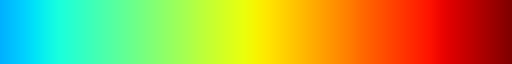

In [3]:
colors2 = plt.cm.jet(np.linspace(0.3, 1, 45))
colors = np.vstack((colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [4]:
stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')

In [5]:
%%time
year_list = np.arange(2011,2021)
ds_list = []
for n,year in enumerate(year_list):
    tmp = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.precip.full.nc'.format(year))
    #tmp2 = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.land.precip.full.nc'.format(year))
    ds_list.append(tmp)
# merge all data
ds_merged = xr.concat(ds_list, pd.Index(year_list, name='year'))

year_list = np.arange(2011,2021)
ds_list = []
for n,year in enumerate(year_list):
    tmp = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.tb.full.nc'.format(year))
    #tmp2 = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.land.Tb.FNL.alltracks.nc'.format(year))
    ds_list.append(tmp)
# merge all data
tb_merged = xr.concat(ds_list, pd.Index(year_list, name='year'))

CPU times: user 1.14 s, sys: 237 ms, total: 1.38 s
Wall time: 1.46 s


In [6]:
# get near climatology from the merged data
ds_all = ds_merged.sel(area_type=(['env','mcs'])).sum(('area_type','duration_type','year','phase'))
prec_cond_clim = ds_all.prec_gpm_sum/ds_all.samples # climatology conditionally-average rainfall
joint_prob = ds_all.samples/np.sum(ds_all.samples)
prec_cond_clim = prec_cond_clim.where(joint_prob > 1e-4)

tb_all = tb_merged.sel(area_type=(['env','mcs'])).sum(('area_type','duration_type','year','phase'))
tb_cond_clim = tb_all.tb_sum/tb_all.samples # climatology conditionally-average Tb 
joint_prob = tb_all.samples/np.sum(tb_all.samples)
tb_cond_clim = tb_cond_clim.where(joint_prob > 1e-4)

#### 2D BL histogram based on MCS grids during MCS phases
- mcs: sampling mcs grids
- over ocean

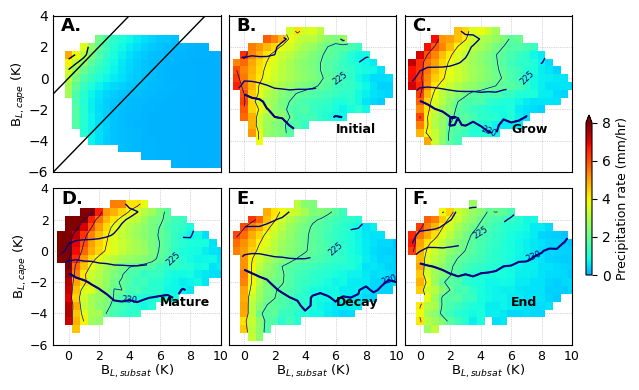

In [8]:
ds_merged_mcs = ds_merged.sel(area_type='mcs').sum(('duration_type','year'))
tb_merged_mcs = tb_merged.sel(area_type='mcs').sum(('duration_type','year'))

# dbl = 0.25
# bins_cape = ds_merged_mcs.bins_cape
# bins_subsat = ds_merged_mcs.bins_subsat
# ds_merged_mcs= ds_merged_mcs.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
#                                             bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
# tb_merged_mcs= tb_merged_mcs.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
#                                             bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label_str) in enumerate(zip([ax2,ax3,ax4,ax5,ax6]
                                        ,['Initial','Grow','Mature','Decay','End']
                                        ,['B.','C.','D.','E.','F.'])):
    
    samples_sub = ds_merged_mcs.samples.sel(phase=phase)
    joint_prob = samples_sub/np.sum(samples_sub)
    prec_sub = ds_merged_mcs.prec_gpm_sum.sel(phase=phase)
    prec_cond_sub = prec_sub/samples_sub
    prec_cond_mask = prec_cond_sub.where(joint_prob > 1e-4)

    # get Tb
    samples_sub = tb_merged_mcs.samples.sel(phase=phase)
    joint_prob = samples_sub/np.sum(samples_sub)
    tb_sub = tb_merged_mcs.tb_sum.sel(phase=phase)
    tb_cond_sub = tb_sub/samples_sub
    tb_cond_mask = tb_cond_sub.where(joint_prob > 1e-4)

    cp = ax.pcolormesh(prec_cond_mask.bins_subsat, prec_cond_mask.bins_cape, prec_cond_mask, vmin=0, vmax=8,
                       cmap=mixedmap, zorder=2)
    #cp.cmap.set_over('k')
    ax.contour(prec_cond_mask.bins_subsat, prec_cond_mask.bins_cape, prec_cond_mask, levels=[2,4,6,8],
                       linewidths=0.5, colors=['navy'], zorder=2)
    cf = ax.contour(samples_sub.bins_subsat, samples_sub.bins_cape, tb_cond_mask, levels=[220,225,230],
                      linewidths=1, colors=['navy'], zorder=2)
    ax.contour(samples_sub.bins_subsat, samples_sub.bins_cape, tb_cond_mask, levels=[230],
                      linewidths=1.5, colors=['navy'], zorder=2) 
    ax.clabel(cf,[225,230], inline_spacing=0.5, fontsize=6)

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Precipitation rate (mm/hr)',fontsize=9)
    
    # add buoyancy reference 
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)
    
    ## configuration of tick, labels
    ax.text(6,-3.5,'{}'.format(phase),fontsize=9,color='k',fontweight='bold')
    ax.text(-0.5,3,'{}'.format(label_str),fontsize=13,fontweight='bold',color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12,14])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-6,4])
    ax.set_xlim([-1,10])   

ax1.tick_params('both', length=0, width=1, which='major')

ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_yticks([-8,-6,-4,-2,0,2,4])
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
plt.tight_layout(h_pad=0.2,w_pad=0.02)

#====== climatology of conditioanlly-averaged precip =======
# add buoyancy reference 
ax1.pcolormesh(prec_cond_clim.bins_subsat, prec_cond_clim.bins_cape, prec_cond_clim, vmin=0, vmax=8,
                       cmap=mixedmap, zorder=2)
ax1.contour(tb_cond_clim.bins_subsat, tb_cond_clim.bins_cape, tb_cond_clim, levels=[220,225,230,235,240],
            linewidths=1, colors=['k'], zorder=3)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
#ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
#ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)
ax1.text(-0.5,3,'A.',fontsize=13,fontweight='bold',color='k')
ax1.text(3,-3.5,'{}'.format(''),fontsize=9,color='k',fontweight='bold')

ax1.set_ylim([-6,4])
ax1.set_xlim([-1,10])
plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig3_MCSgridsBL_fraction_occurrence.all.ameanBL0.1.pdf',
#      bbox_inches='tight',transparent=False)

### whether MCSs over land actually produce weaker rainfalls
- simply 1-D precipitation histogram for mcs grids
- expecting higher probability of strong rain rates within MCSs over oceans compared to land
- 1-D Buoy-Precip over land and oceans? same critical pick-up but lower rain rate over land? coming from lower CWV?

In [27]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/')
precip_hist = xr.open_dataset(out_dir / 'MCS_precip_intensity_pdf_landsea.nc')
bins_precip = precip_hist.bins_precip
phist_oce = precip_hist.sel(surface_type='ocean').samples
phist_lnd = precip_hist.sel(surface_type='land').samples

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(bins_precip, phist_oce/phist_oce.sum(), lw=1.5, marker='o',ms=5, color='b', label='Ocean')
ax.plot(bins_precip, phist_lnd/phist_lnd.sum(), lw=1.5, marker='o',ms=5, color='limegreen', label='Land')
ax.set_yscale('log')
ax.set_xlabel('Precipitation rate (mm/hr)', fontsize=10)
ax.set_ylabel('Log(Probabolity)', fontsize=10)
ax.set_title('Frequency of precipitation intensity \n Tropical MCS (30S-30N), 0.25-deg. GPM', fontsize=10)
ax.set_ylim([1e-5, 1])
ax.set_xlim([0,100])
ax.grid(lw=1, ls=':')
ax.legend()
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/PDF_precipitation_intensity_landsea.pdf',
           bbox_inches='tight',transparent=False)